# Imports

In [1]:
%load_ext jupyter_black
%matplotlib inline

In [35]:
import re
import optuna
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.io import show
from typing import Optional
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS
from lightgbm import LGBMRegressor as lgbm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")


def rmse(a, b):
    return mse(a, b, squared=False)

# Input Datasets

In [36]:
train = pd.read_csv("inputs/train.csv").drop(columns="id")
test = pd.read_csv("inputs/test.csv").drop(columns="id")
submission = pd.read_csv("inputs/sample_submission.csv")

pre_concat_shape = train.shape
# Adding original used cars dataset to the training as some categories seen in the test didnt have representation in the training dataset
used_cars_dataset = pd.read_csv("inputs/used_cars.csv")
used_cars_dataset[["milage", "price"]] = used_cars_dataset[["milage", "price"]].map(
    lambda x: int("".join(re.findall(r"\d+", x)))
)
train = pd.concat([train, used_cars_dataset], ignore_index=True)

print(
    f"Train Dataset Size : {pre_concat_shape} \nTest Dataset Size : {test.shape} \nOriginal Dataset Size : {used_cars_dataset.shape}"
)

Train Dataset Size : (188533, 12) 
Test Dataset Size : (125690, 11) 
Original Dataset Size : (4009, 12)


In [37]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [38]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


# EDA

## Helper Functions

### Plotting Functions

In [39]:
def plot_countplot(
    train: pd.DataFrame,
    test: Optional[pd.DataFrame],
    col: str,
    topN: Optional[int] = None,
) -> None:
    """
    Plots count plots of a specified column from the training and optionally the test dataset.

    Args:
        train (pd.DataFrame): The training dataset.
        test (Optional[pd.DataFrame]): The test dataset. If None, only the training dataset is plotted.
        col (str): The column to plot the count plot for.
        topN (Optional[int]): Limits the plot to the top N categories if provided.

    Returns:
        None
    """
    train_order = train[col].value_counts().index

    if test is not None:
        test_order = test[col].value_counts().index

    if topN:
        train_order = train_order[0:topN]
        test_order = test_order[0:topN]

    if test is not None:
        r = 1
        c = 2
        s = (22, 6)
    else:
        r = 1
        c = 1
        s = (11, 6)

    fig, axes = plt.subplots(r, c, figsize=s)
    if test is not None:
        sns.countplot(data=train, x=col, ax=axes[0], order=train_order)
        sns.countplot(data=test, x=col, ax=axes[1], order=test_order)
        axes[0].set_title(f"{col} in Train Dataset")
        axes[1].set_title(f"{col} in Test Dataset")
        plt.setp(axes[0].get_xticklabels(), rotation=60, ha="right")
        plt.setp(axes[1].get_xticklabels(), rotation=60, ha="right")
        plt.show()
    else:
        sns.countplot(data=train, x=col, ax=axes, order=train_order)
        axes.set_title(f"{col} in Train Dataset")
        plt.setp(axes.get_xticklabels(), rotation=60, ha="right")
        plt.show()


def plot_distplot(train: pd.DataFrame, test: pd.DataFrame, col: str) -> None:
    """
    Plots the distribution of a specified column for the training and test datasets using histograms.

    Args:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The test dataset.
        col (str): The column to plot the distribution for.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    sns.histplot(train[col], ax=axes[0])
    sns.histplot(test[col], ax=axes[1])
    axes[0].set_title(f"{col} distribution in Train Dataset")
    axes[1].set_title(f"{col} distribution in Test Dataset")
    plt.show()

## Check if all test categories are in train

In [40]:
for col in train.columns:
    if train[col].dtype == "object":
        train_categories = set(train[col].unique())
        test_categories = set(test[col].unique())

        print("-" * 10, col, "-" * 10)

        unseen_categories = test_categories - train_categories

        if not unseen_categories:
            print("All categories in the test set are also in the training set.")
        else:
            print(
                "The following categories are present in the test set but missing in the training set:",
                unseen_categories,
            )

---------- brand ----------
All categories in the test set are also in the training set.
---------- model ----------
All categories in the test set are also in the training set.
---------- fuel_type ----------
All categories in the test set are also in the training set.
---------- engine ----------
All categories in the test set are also in the training set.
---------- transmission ----------
All categories in the test set are also in the training set.
---------- ext_col ----------
All categories in the test set are also in the training set.
---------- int_col ----------
All categories in the test set are also in the training set.
---------- accident ----------
All categories in the test set are also in the training set.
---------- clean_title ----------
All categories in the test set are also in the training set.


## Feature Plots

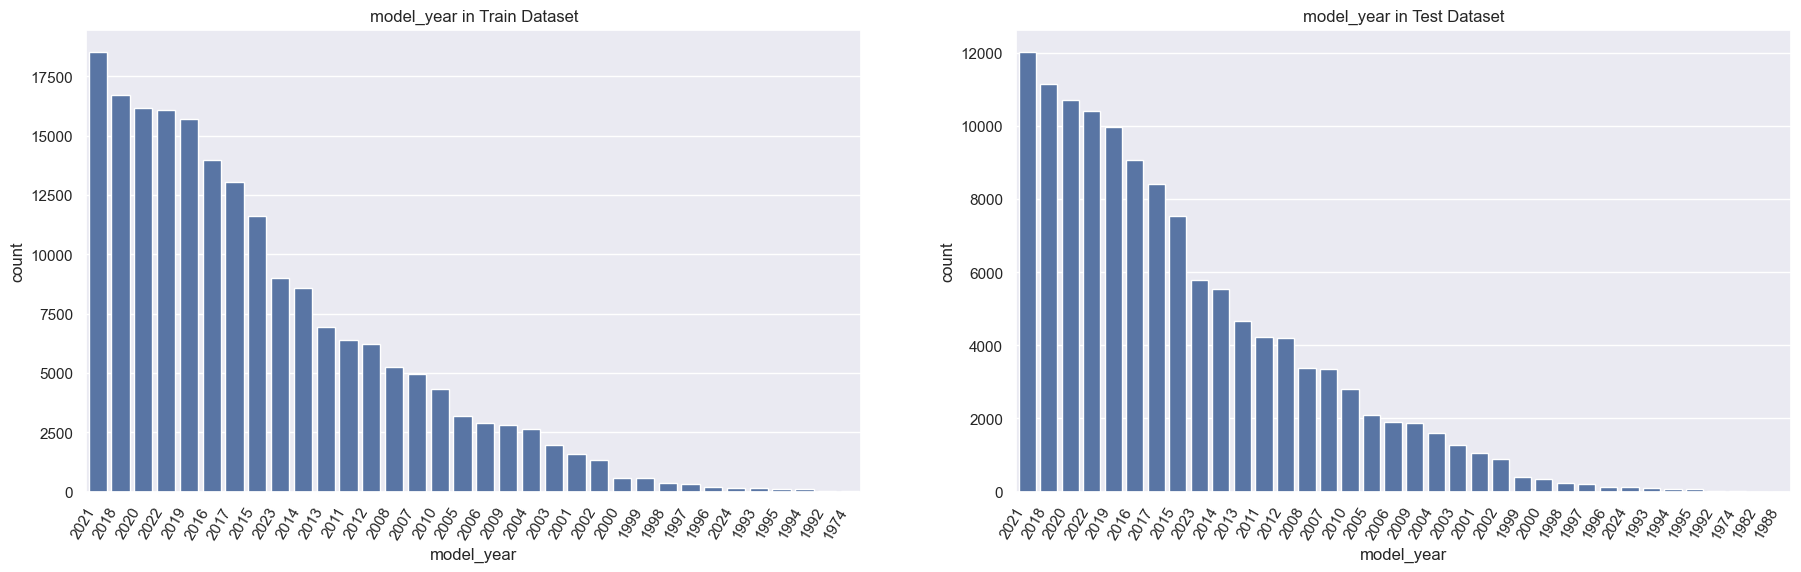

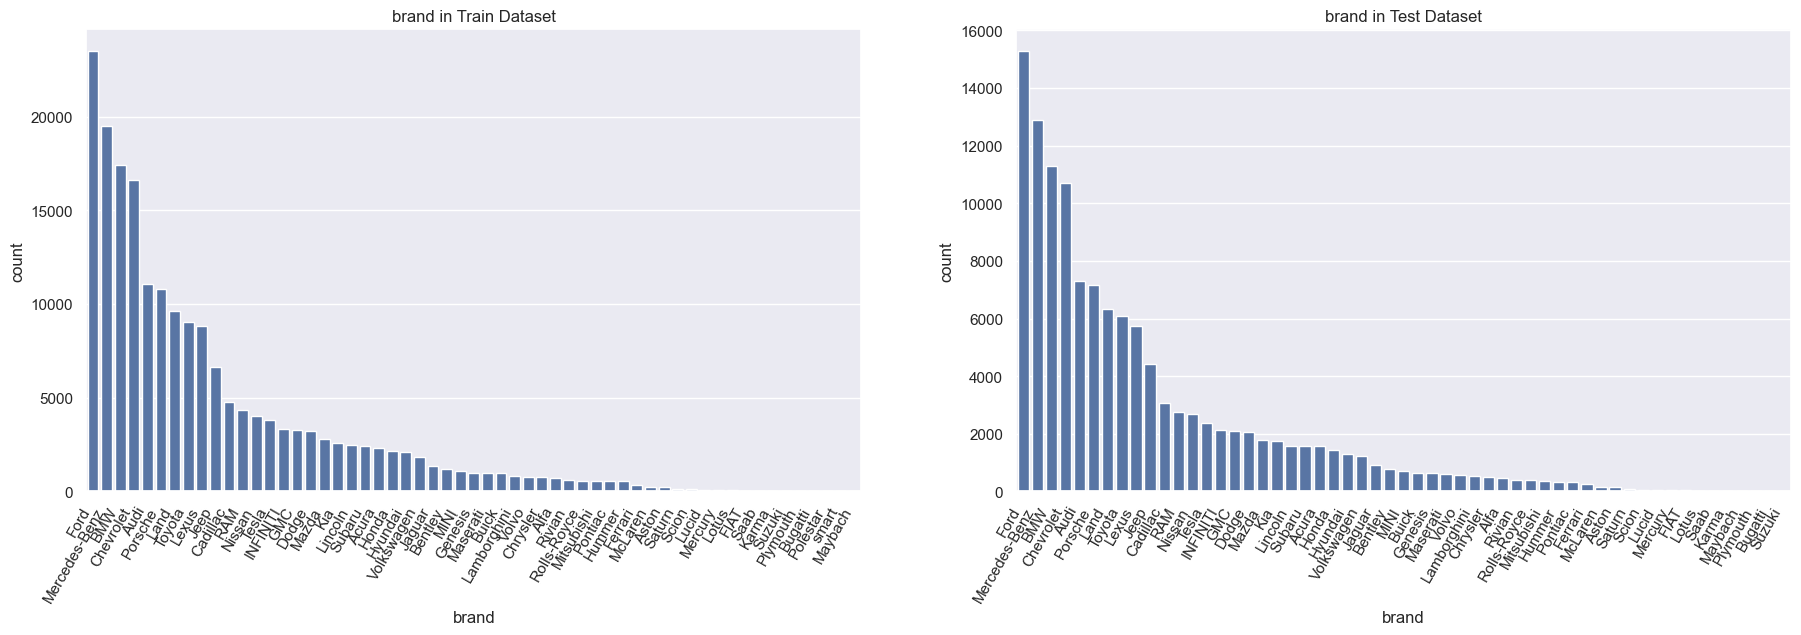

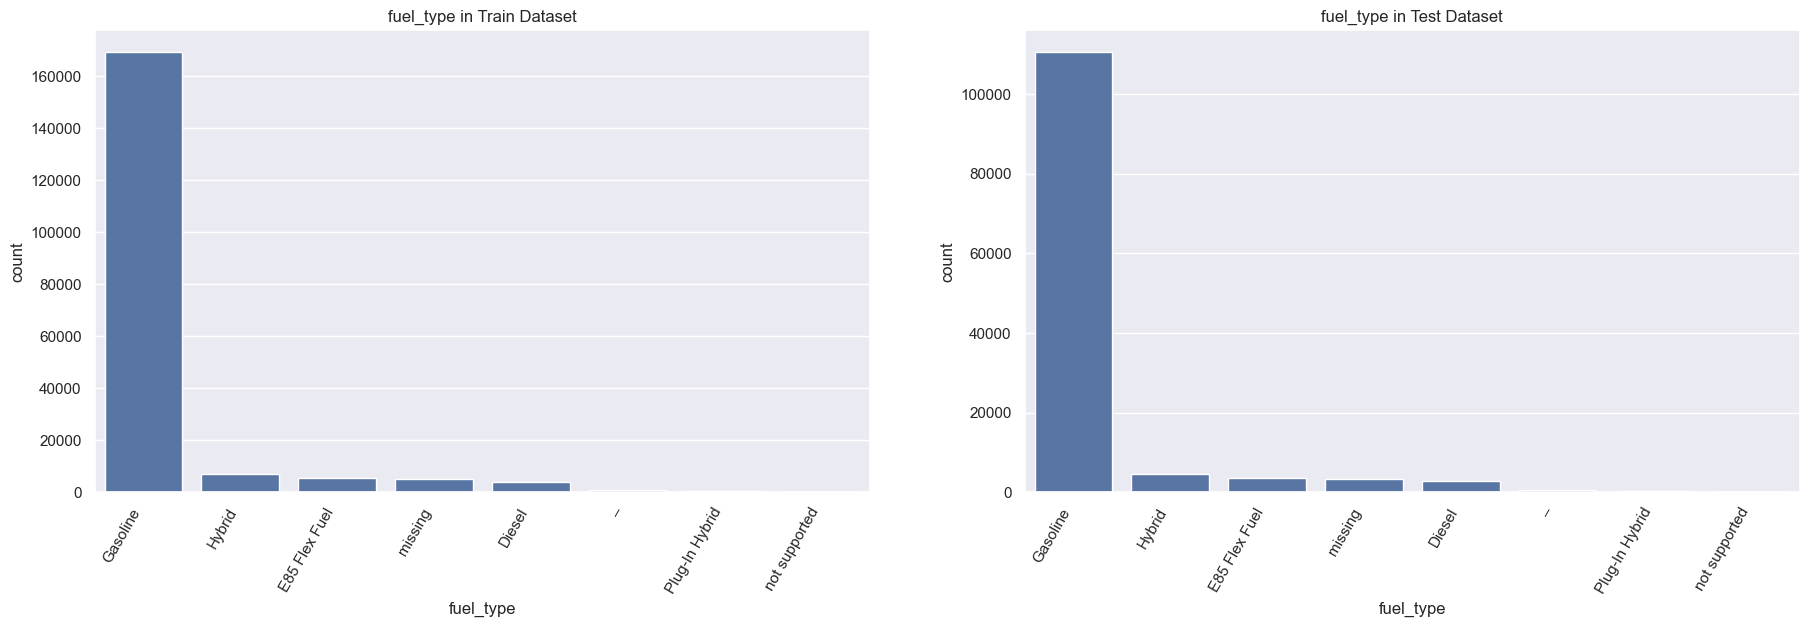

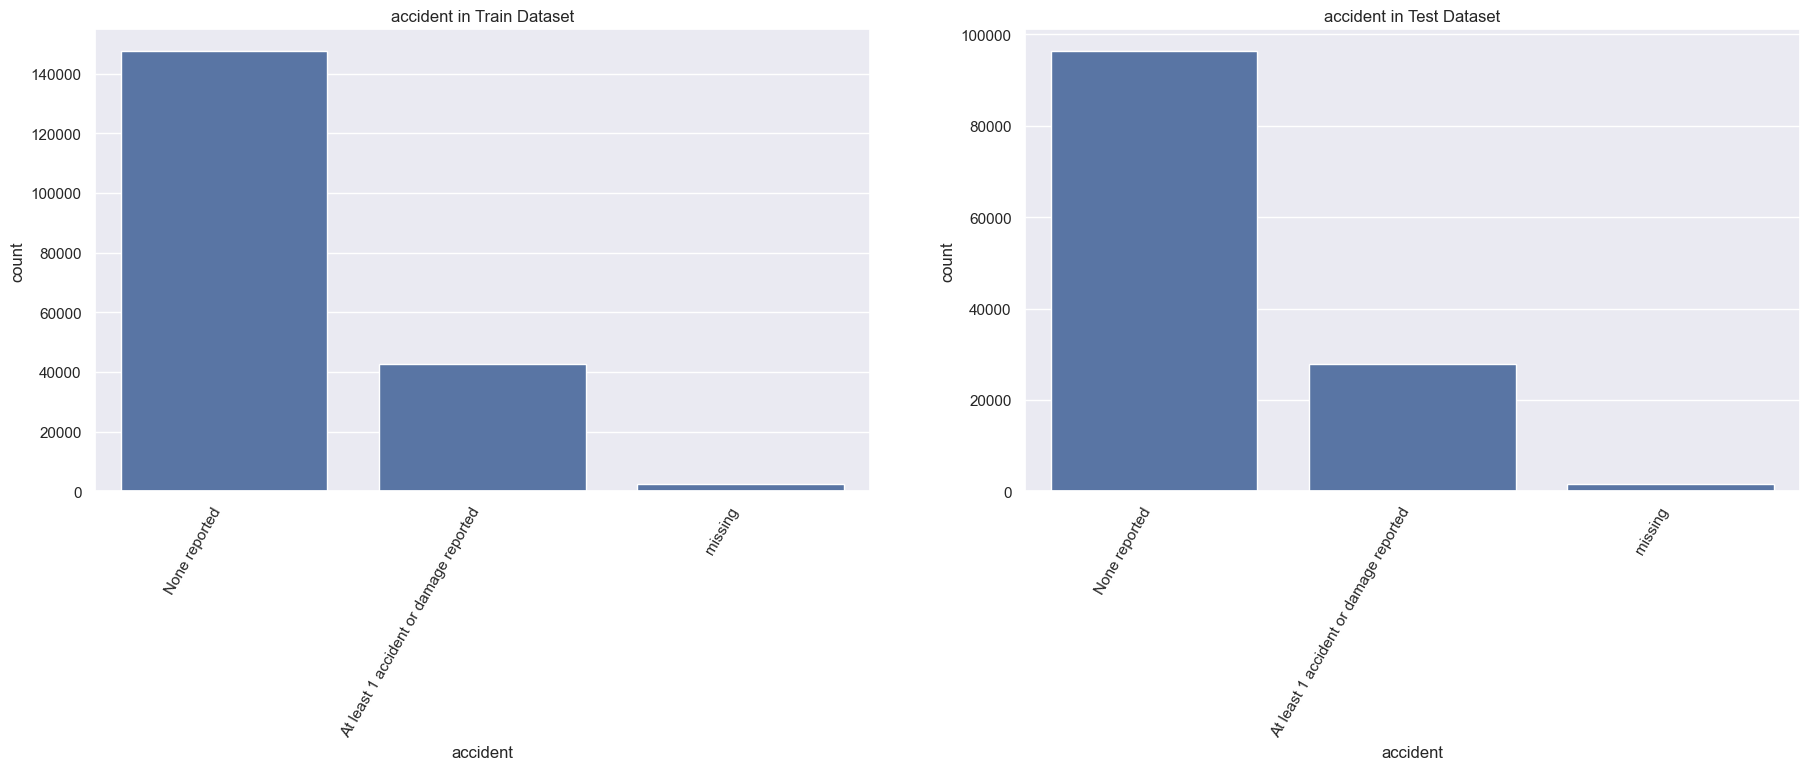

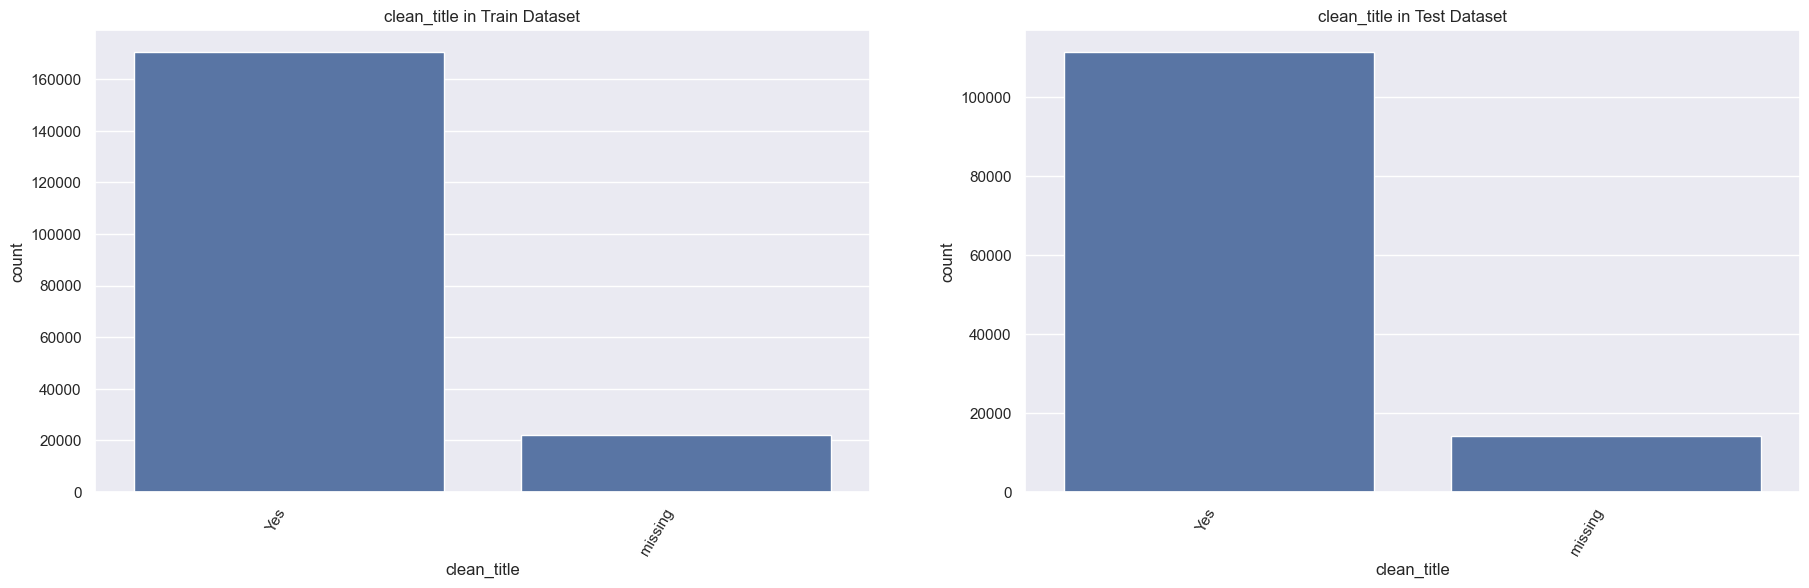

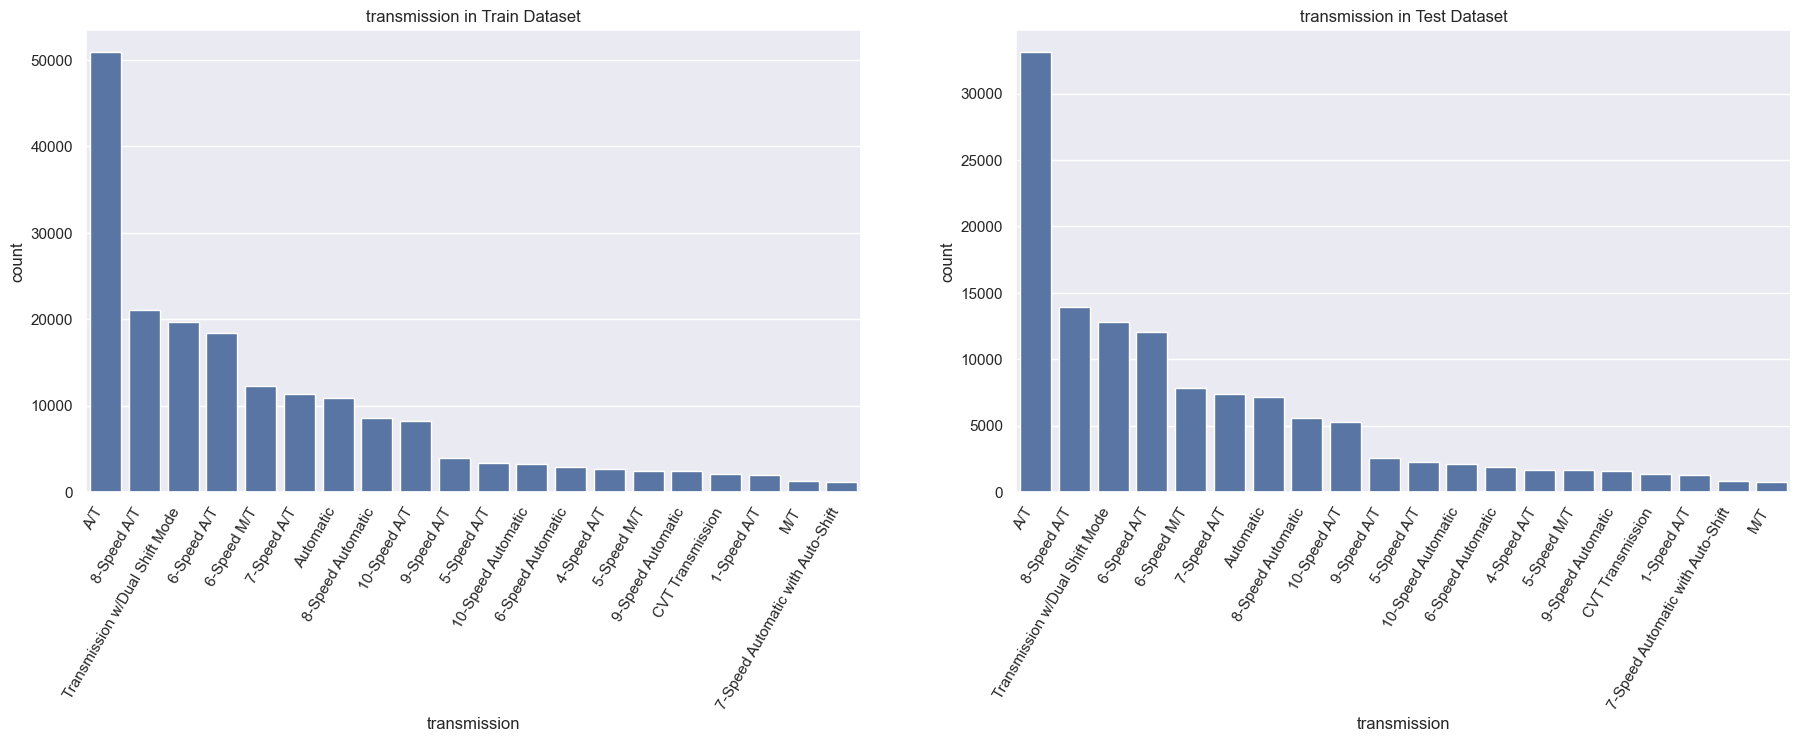

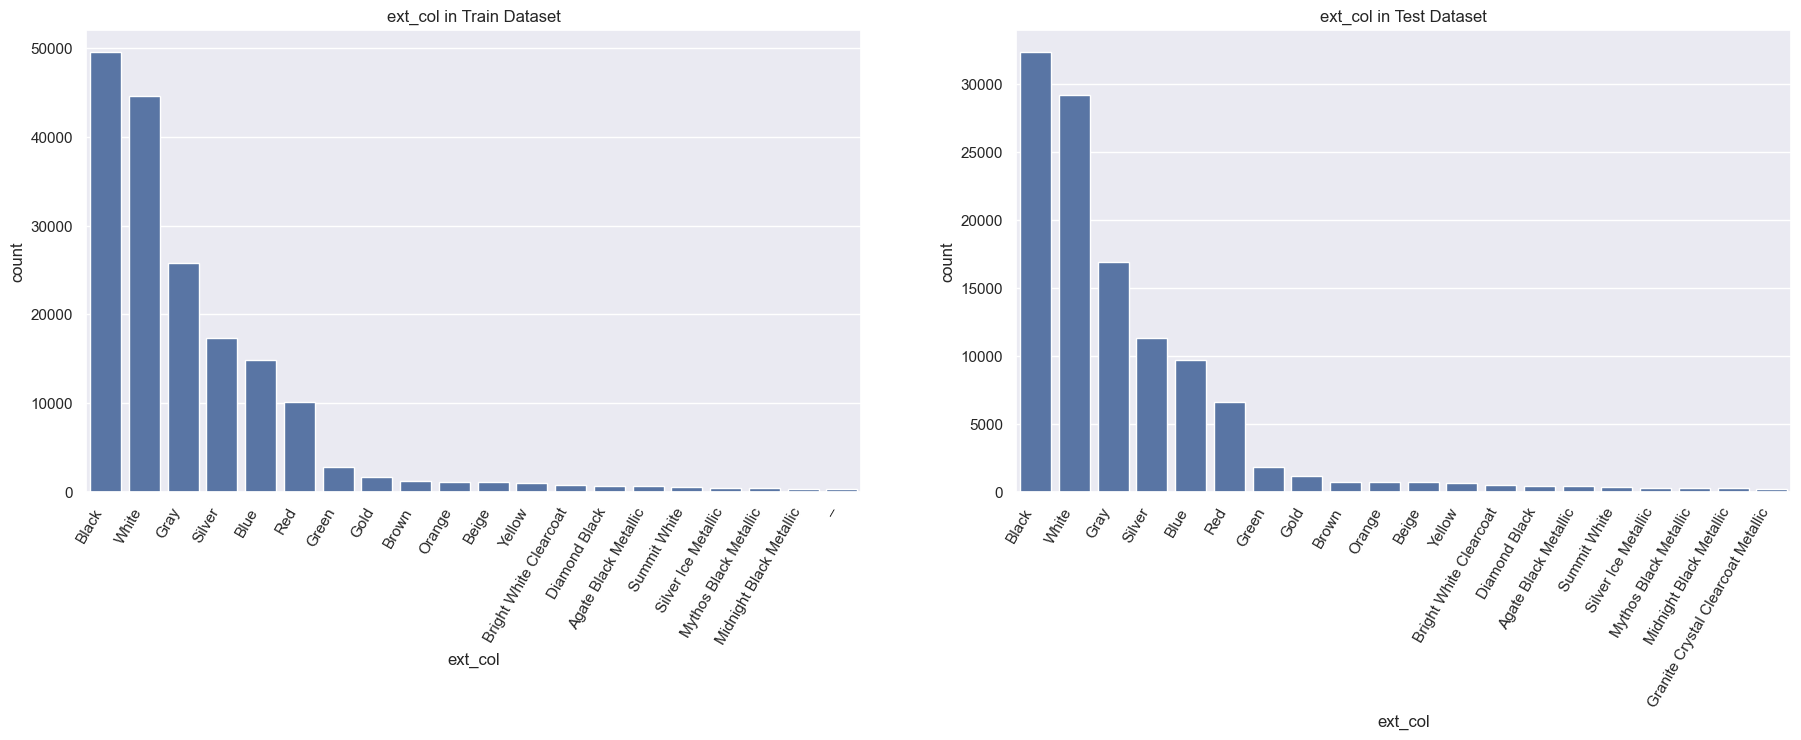

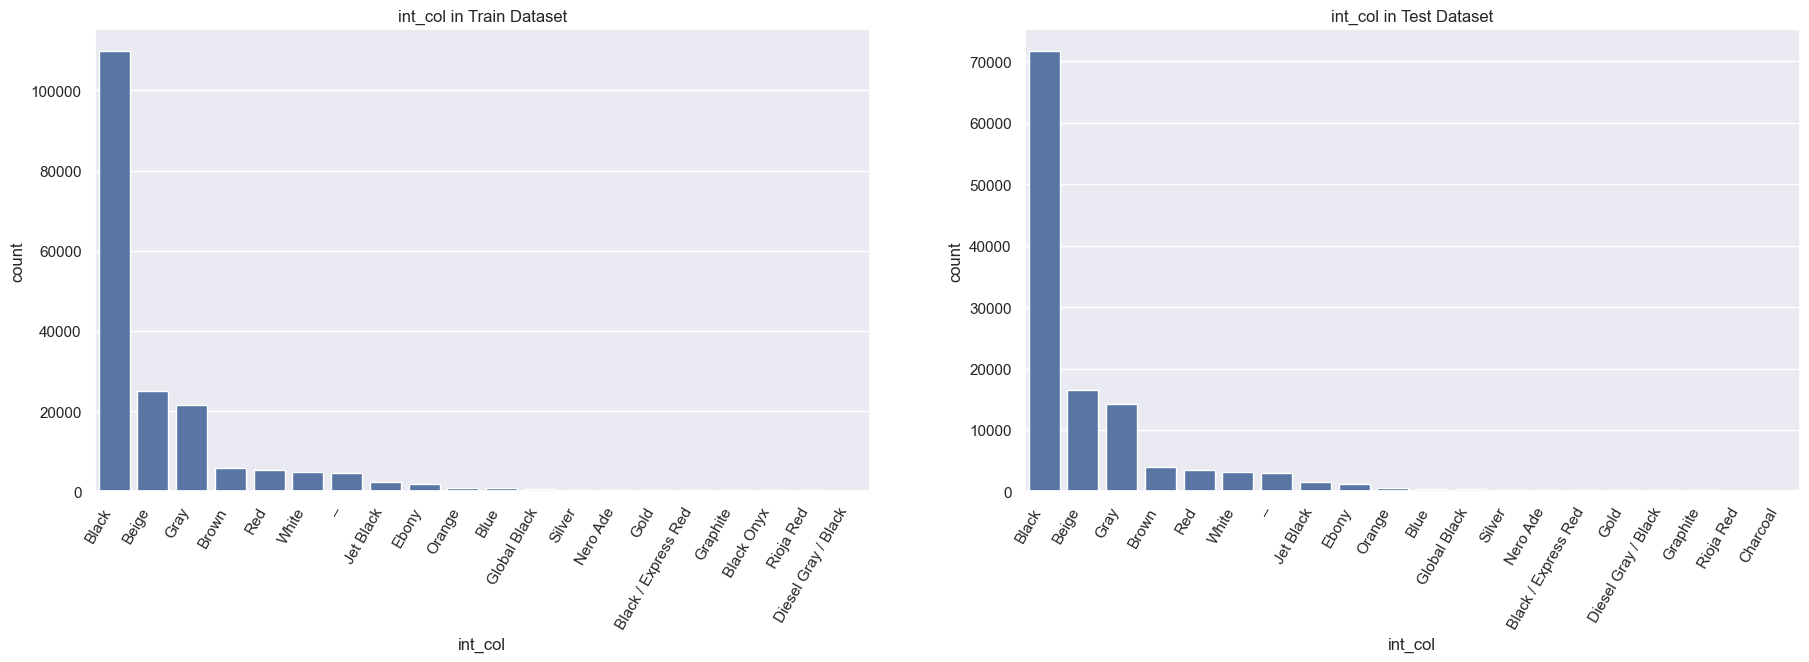

In [8]:
for col in ["model_year", "brand", "fuel_type", "accident", "clean_title"]:
    plot_countplot(train.fillna("missing"), test.fillna("missing"), col)
for col in ["transmission", "ext_col", "int_col"]:
    plot_countplot(train.fillna("missing"), test.fillna("missing"), col, topN=20)

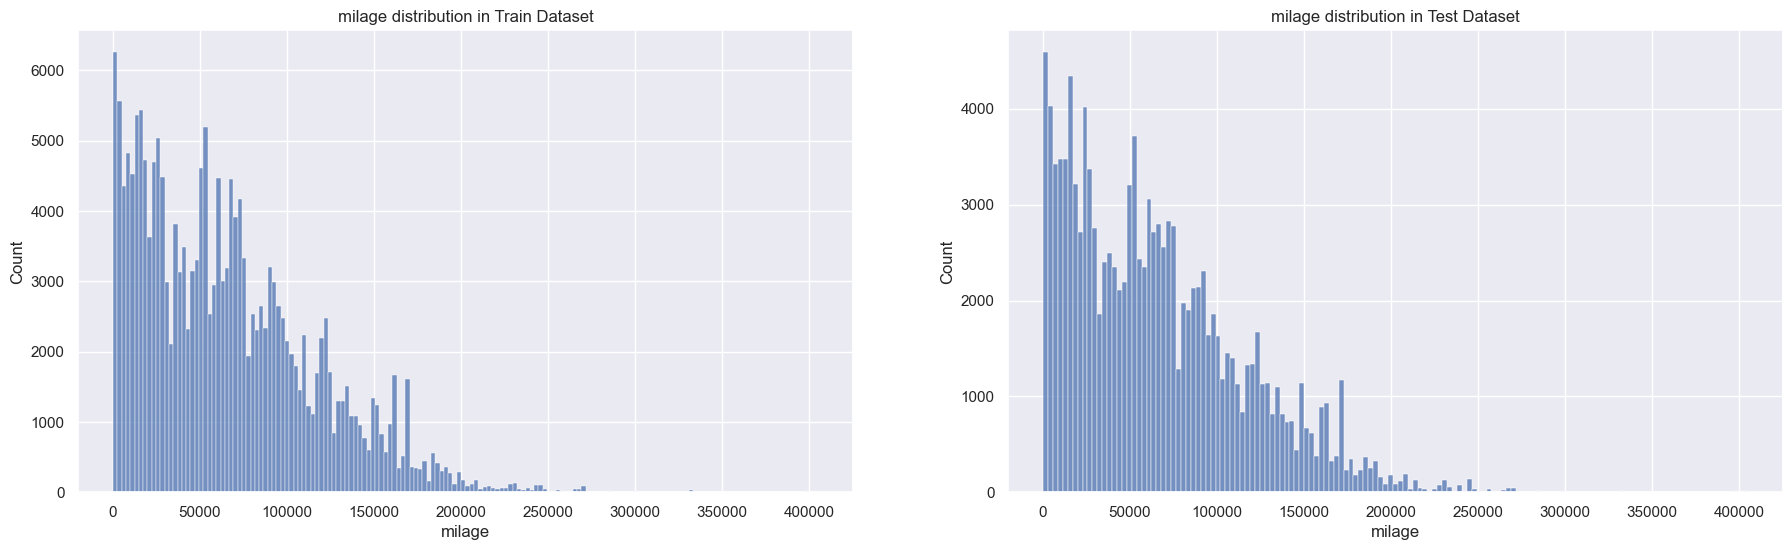

In [9]:
plot_distplot(train, test, col="milage")

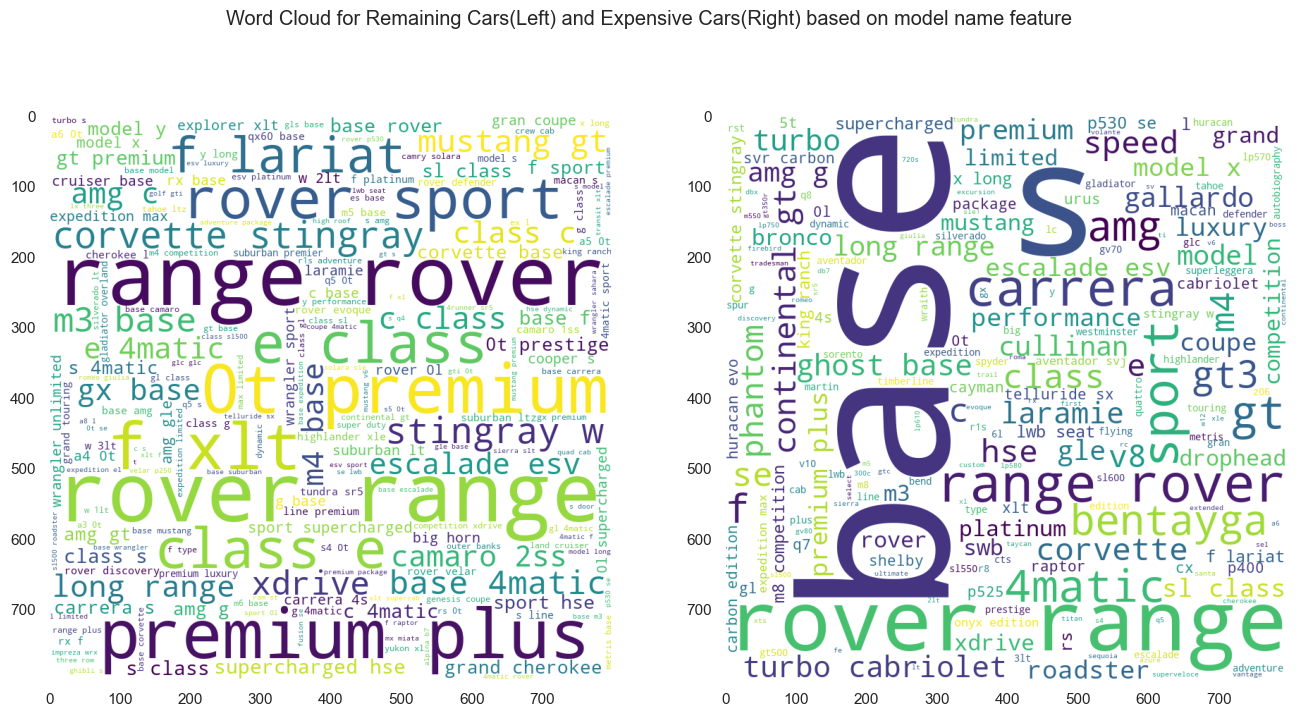

In [10]:
comment_words_remaining_cars = ""
comment_words_expensive_cars = ""
stopwords = set(STOPWORDS)

for val in train[train["price"] <= 500000].model:
    tokens = [i.lower() for i in val.split()]
    comment_words_remaining_cars += " ".join(tokens) + " "

for val in train[train["price"] > 500000].model:
    tokens = [i.lower() for i in val.split()]
    comment_words_expensive_cars += " ".join(tokens) + " "

wordcloud_remaining_cars = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words_remaining_cars)

wordcloud_expensive_cars = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words_expensive_cars)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_remaining_cars)
axes[1].imshow(wordcloud_expensive_cars)
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle(
    "Word Cloud for Remaining Cars(Left) and Expensive Cars(Right) based on model name feature"
)
plt.show()

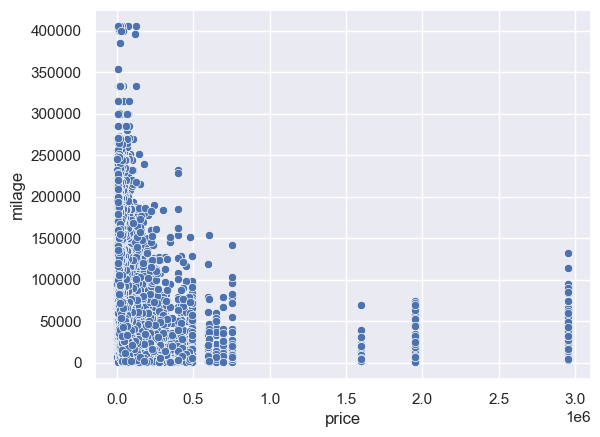

In [11]:
sns.scatterplot(data=train, x="price", y="milage")
plt.show()

## Null Values 

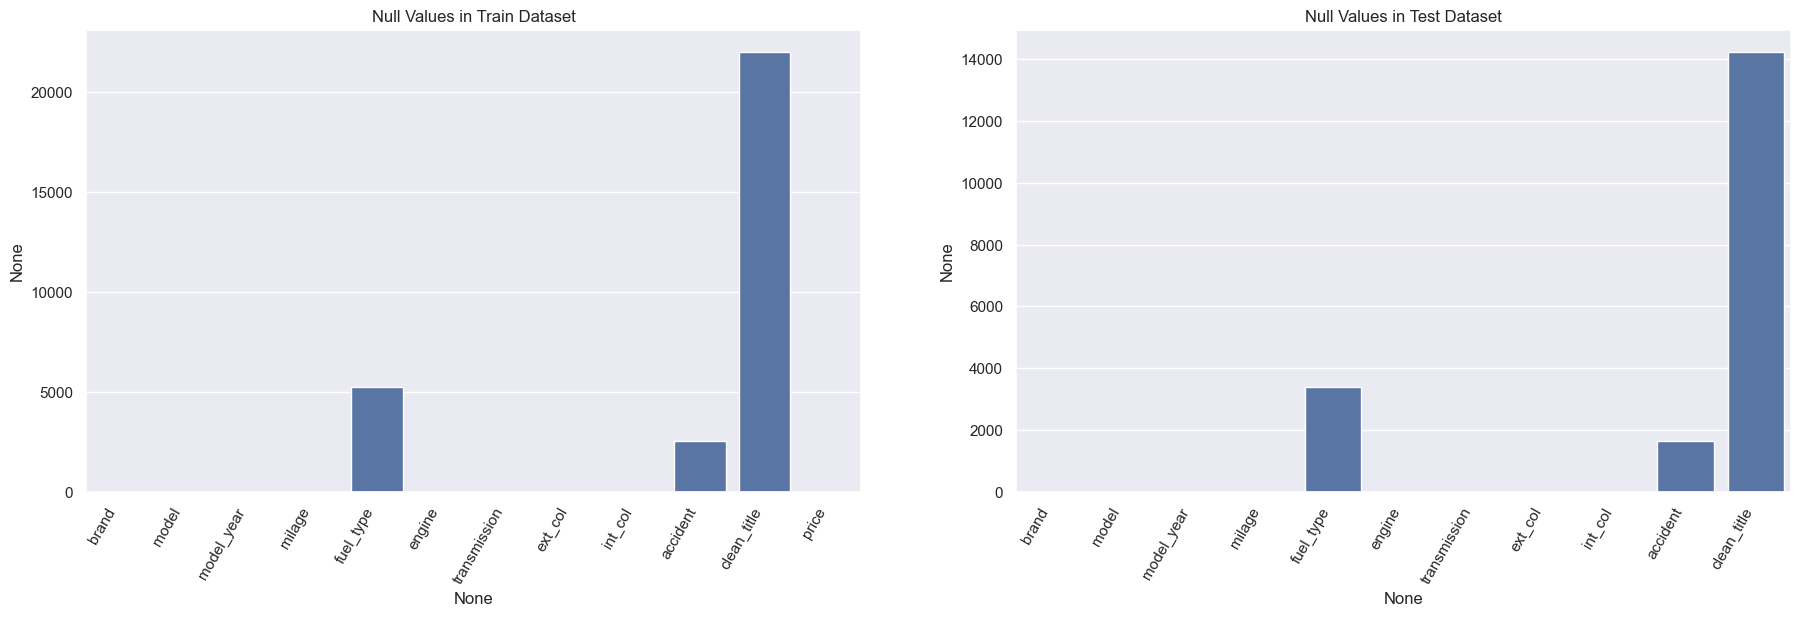

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(22, 6))
sns.barplot(x=train.columns, y=train.isna().sum(), ax=axes[0])
sns.barplot(x=test.columns, y=test.isna().sum(), ax=axes[1])
axes[0].set_title("Null Values in Train Dataset")
axes[1].set_title("Null Values in Test Dataset")
plt.setp(axes[0].get_xticklabels(), rotation=60, ha="right")
plt.setp(axes[1].get_xticklabels(), rotation=60, ha="right")
plt.show()

# Modelling

In [13]:
def clean_data(df, threshold=100):
    """
    Cleans categorical columns by replacing low-frequency values with 'noise' and filling missing values.

    This function processes categorical columns in the provided dataframe by:
    1. Replacing values that occur less than the specified threshold with the label 'noise'.
    2. Filling missing (NaN) values with the label 'missing'.
    3. Converting the columns to the 'category' data type for memory efficiency and easier handling of categorical data.

    Args:
        df (pd.DataFrame): The dataframe containing the data to be cleaned.
        threshold (int, optional): The minimum frequency threshold for a value to be retained.
                                   Values occurring fewer times than the threshold will be replaced with 'noise'.
                                   Default is 100.

    Returns:
        pd.DataFrame: The cleaned dataframe with updated categorical columns.
    """

    cat_columns = [
        "brand",
        "model",
        "fuel_type",
        "engine",
        "transmission",
        "ext_col",
        "int_col",
        "accident",
        "clean_title",
    ]

    for col in cat_columns:
        value_counts = df[col].value_counts(dropna=False)
        low_freq_mask = df[col].map(value_counts) < threshold
        df.loc[low_freq_mask, col] = "noise"
        df[col] = df[col].fillna("missing").astype("category")

    return df


def k_fold_cv(
    model, X, y, test, k=5, scoring="root_mean_squared_error", random_state=None
):
    """
    Perform K-fold cross-validation for a given model.

    This function applies K-fold cross-validation to a specified model and computes training and validation
    scores for each fold. It also generates predictions for the test dataset by averaging the predictions from each fold.

    Args:
        model: The machine learning model to be trained and validated. It should implement the `fit` and `predict` methods.
        X (pd.DataFrame or np.array): The input features used for training the model.
        y (pd.Series or np.array): The target variable associated with the input features.
        test (pd.DataFrame or np.array): The test dataset on which predictions are made after each fold.
        k (int, optional): The number of folds for K-fold cross-validation. Default is 5.
        scoring (str, optional): The metric used to evaluate model performance. Currently only supports "root_mean_squared_error".
                                 Default is "root_mean_squared_error".
        random_state (int, optional): Controls the randomness of data shuffling. Default is None.

    Returns:
        model: The trained model after cross-validation.
        np.array: The averaged predictions across all folds for the test dataset.

    Prints:
        - Train and validation RMSE for each fold.
        - Mean train and validation scores with their standard deviation across all folds.
    """

    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    train_scores = []
    val_scores = []
    test_predictions = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        if scoring == "root_mean_squared_error":
            train_score = rmse(y_train, y_train_pred)
            val_score = rmse(y_val, y_val_pred)
        else:
            raise ValueError(f"Scoring method '{scoring}' not supported.")

        train_scores.append(train_score)
        val_scores.append(val_score)
        print(f"Fold {fold + 1}/{k} -> Train RMSE: {train_score} Val RMSE: {val_score}")

        # Predict on test set and store for averaging later
        test_predictions.append(model.predict(test))

    print(f"Train Mean Score: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
    print(f"Val Mean Score: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

    return model, np.array(test_predictions).mean(axis=0)


def plot_feature_importance(model, feature_names: list) -> None:
    """
    Plots the feature importance for a given model.

    Args:
        model: A trained model that has a `feature_importances_` attribute (e.g., tree-based models like RandomForest, XGBoost, LGBM).
        feature_names (list): List of feature names corresponding to the model input.

    Returns:
        None
    """
    # Get feature importances from the model
    try:
        importances = model.feature_importances_
    except AttributeError:
        raise ValueError("The model does not have a 'feature_importances_' attribute.")

    # Create a DataFrame to pair feature names with their importance
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

    # Sort the DataFrame by feature importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


def actual_vs_pred(actual, pred, xlim=(0, 500000)):
    """
    Plot the distribution of actual vs predicted values with KDE lines.

    This function visualizes the distribution of actual and predicted values
    using histograms with Kernel Density Estimation (KDE) lines overlaid for
    both. The plot helps to compare how closely the predicted values match the
    actual distribution.

    Args:
        actual (array-like): The actual target values.
        pred (array-like): The predicted values from the model.
        xlim (tuple, optional): A tuple to limit the range of the x-axis.
                                Default is (0, 500000).

    Returns:
        None: The function outputs a plot and doesn't return any values.
    """
    # Plot the actual values and predicted values with KDE lines
    sns.histplot(actual, label="Actual", kde=True, alpha=1)
    sns.histplot(pred, label="Predicted", kde=True, alpha=0.3)

    # Set x-axis limits
    plt.xlim(xlim)

    # Add labels and legend
    plt.legend()
    plt.xlabel("Values")
    plt.title("Actual vs Predicted Distribution")

    # Show the plot
    plt.show()

## Base Feature No Hyper Parameter Tuning

In [41]:
train_cleaned = clean_data(train.copy())
test_cleaned = clean_data(test.copy())
X = train_cleaned.drop(columns=["price"])
features = X.columns
y = train_cleaned["price"]

In [16]:
random_state = 42
kfold = 10

model = lgbm(random_state=random_state, verbose=-1)
model, test_prediction = k_fold_cv(
    model,
    X,
    y,
    test_cleaned,
    k=kfold,
    scoring="root_mean_squared_error",
    random_state=random_state,
)

plot_feature_importance(model, features)

actual_vs_pred(y, model.predict(X))

Fold 1/10 -> Train RMSE: 66082.54222481856 Val RMSE: 72331.13163920741
Fold 2/10 -> Train RMSE: 65152.81138150162 Val RMSE: 78869.17741295943
Fold 3/10 -> Train RMSE: 65773.06434354708 Val RMSE: 74522.50560387727
Fold 4/10 -> Train RMSE: 66792.37660400892 Val RMSE: 62570.15955308005
Fold 5/10 -> Train RMSE: 66108.02350873289 Val RMSE: 70923.82870756816
Fold 6/10 -> Train RMSE: 66239.15728718431 Val RMSE: 69519.24028865252
Fold 7/10 -> Train RMSE: 65650.31467210155 Val RMSE: 79147.69865235228
Fold 8/10 -> Train RMSE: 65948.87022558111 Val RMSE: 71754.07659145168
Fold 9/10 -> Train RMSE: 66305.38967292392 Val RMSE: 70506.2795201752
Fold 10/10 -> Train RMSE: 65198.17420355262 Val RMSE: 79968.24734972719
Train Mean Score: 65925.0724 ± 477.2534
Val Mean Score: 73011.2345 ± 5064.9854


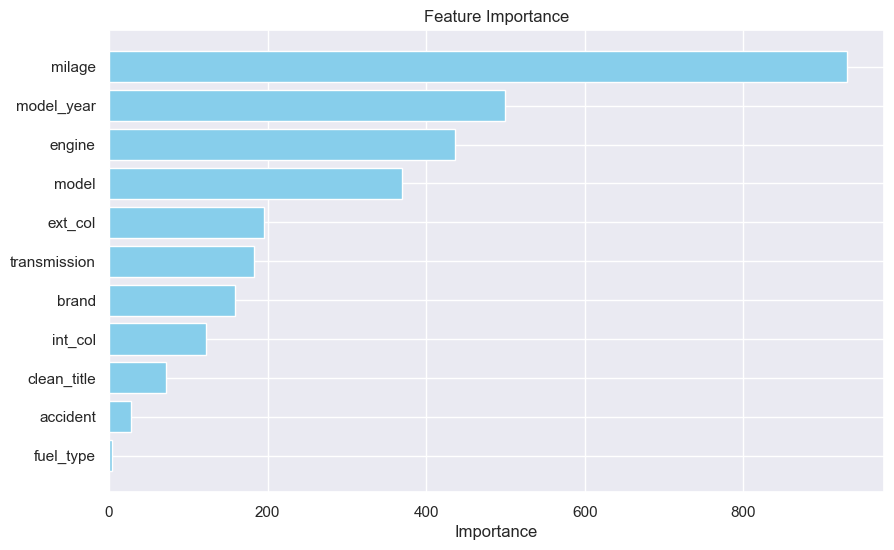

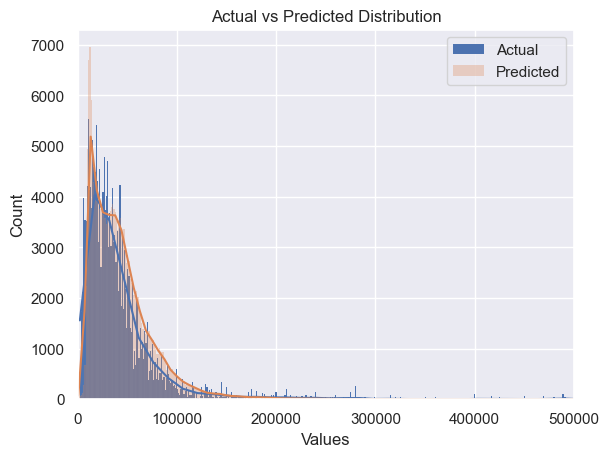

In [19]:
# LB Score = 72697.18383

# Save the model
with open("outputs/lgbm_model_base_features_no_hyperP_tune.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the predictions
submission["price"] = test_prediction
submission.to_csv("outputs/lgbm_model_base_features_no_hyperP_tune.csv", index=False)
submission.head()

,id,price
0,188533,17993.743968
1,188534,83654.528194
2,188535,55615.507168
3,188536,25060.583304
4,188537,30261.539807


## Base Feature with Hyper Param Tuning

In [28]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    reg_alpha = trial.suggest_float("reg_alpha", 0.01, 0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 1, 10)
    num_leaves = trial.suggest_int("num_leaves", 50, 300)
    subsample = trial.suggest_float("subsample", 0, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)

    model = lgbm(
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        verbose=-1,
    )

    score = cross_val_score(
        model, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return score


def execute_optuna(n_trials, random_state, study_name):
    if isinstance(n_trials, list):
        n_trials_run = n_trials[1]
        n_trials = sum(n_trials)
    else:
        n_trials_run = n_trials
    storage = "sqlite:///my_study.db"  # Local SQLite database file

    # Create or load a study
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="maximize",
        sampler=TPESampler(seed=random_state),
        load_if_exists=True,
    )

    study.optimize(objective, n_trials=n_trials_run)

    # Load the existing study
    study = optuna.load_study(study_name=study_name, storage=storage)

    fig = optuna.visualization.plot_optimization_history(study)
    show(fig)
    fig = optuna.visualization.plot_parallel_coordinate(study)
    show(fig)
    fig = optuna.visualization.plot_param_importances(study)
    show(fig)

    print(f"Best Params: {study.best_params}")

    return study


def run_cv_on_best_study_params(X, y, test, study_params, random_state=42, kfold=10):
    model = lgbm(**study_params, random_state=random_state, verbose=-1)
    model, test_prediction = k_fold_cv(
        model,
        X,
        y,
        test,
        k=kfold,
        scoring="root_mean_squared_error",
        random_state=random_state,
    )

    plot_feature_importance(model, X.columns)

    return model, test_prediction


def save_outputs(model, model_name, test_predictions):
    # Save the model
    with open(f"outputs/{model_name}.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save the predictions
    submission["price"] = test_predictions
    submission.to_csv(f"outputs/{model_name}.csv", index=False)
    print(submission.head())

In [21]:
n_trials = 20
random_state = 42
kfold = 10

# Define the study name and storage path (local SQLite database file)
study_name = f"lgbm_model_base_features"
storage = "sqlite:///my_study.db"

study = execute_optuna(
    n_trials=n_trials, random_state=random_state, study_name=study_name
)

# Load the existing study
study = optuna.load_study(study_name=study_name, storage=storage)

[I 2024-09-06 11:38:03,060] A new study created in RDB with name: lgbm_model_base_features
[I 2024-09-06 11:38:08,334] Trial 0 finished with value: -73493.87828200521 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 48, 'reg_alpha': 0.07587945476302646, 'reg_lambda': 6.387926357773329, 'num_leaves': 89, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: -73493.87828200521.
[I 2024-09-06 11:38:23,169] Trial 1 finished with value: -72933.7027598678 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 34, 'reg_alpha': 0.0737265320016441, 'reg_lambda': 1.185260448662222, 'num_leaves': 293, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 1 with value: -72933.7027598678.
[I 2024-09-06 11:38:34,222] Trial 2 finished with value: -72707.68809369228 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 17, 'reg_alpha': 0.0373818018663584, 'reg_lambda': 5.7

Best Params: {'learning_rate': 0.029096222045561136, 'max_depth': 11, 'reg_alpha': 0.038894815207758546, 'reg_lambda': 4.99096925410482, 'num_leaves': 211, 'subsample': 0.3203181997429707, 'colsample_bytree': 0.4343562717564112}


Running K-Fold CV on the Best Study Hyperparameters
Fold 1/10 -> Train RMSE: 69014.89412384575 Val RMSE: 72070.4756556292
Fold 2/10 -> Train RMSE: 68257.8020359472 Val RMSE: 78331.69889334477
Fold 3/10 -> Train RMSE: 68820.85510054253 Val RMSE: 74100.62377619879
Fold 4/10 -> Train RMSE: 69908.39530248102 Val RMSE: 61708.008722842555
Fold 5/10 -> Train RMSE: 69163.10908685878 Val RMSE: 70401.75858997904
Fold 6/10 -> Train RMSE: 69365.87055239544 Val RMSE: 68533.48418538952
Fold 7/10 -> Train RMSE: 68235.38777057851 Val RMSE: 78711.2349128925
Fold 8/10 -> Train RMSE: 69019.64895305519 Val RMSE: 71022.38538459787
Fold 9/10 -> Train RMSE: 69089.90161212232 Val RMSE: 70715.40294653781
Fold 10/10 -> Train RMSE: 68108.97498338672 Val RMSE: 79526.61908854137
Train Mean Score: 68898.4840 ± 534.1153
Val Mean Score: 72512.1692 ± 5164.0837


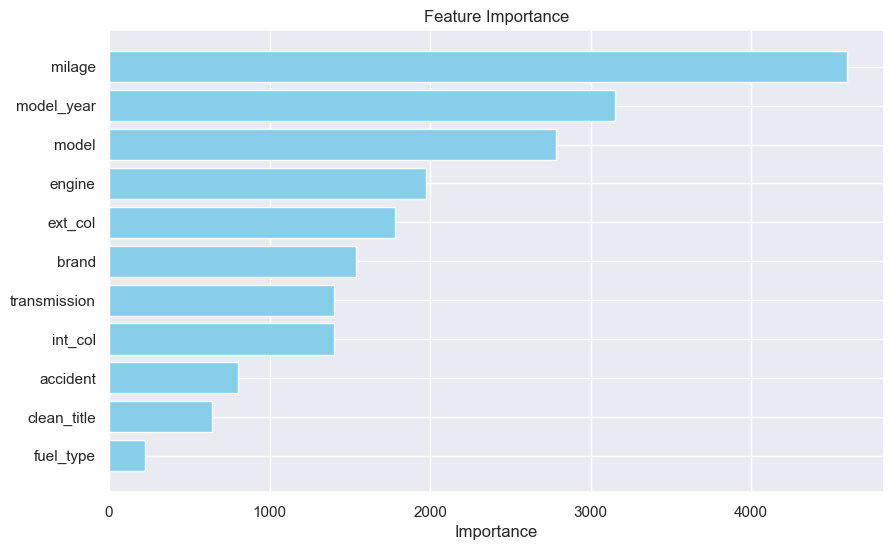

In [30]:
params = study.best_params
print("Running K-Fold CV on the Best Study Hyperparameters")
model, test_prediction = run_cv_on_best_study_params(
    X, y, test_cleaned, params, random_state=random_state, kfold=kfold
)

save_outputs(
    model=model,
    model_name=f"lgbm_model_base_features_hyperP_tune",
    test_predictions=test_prediction,
)

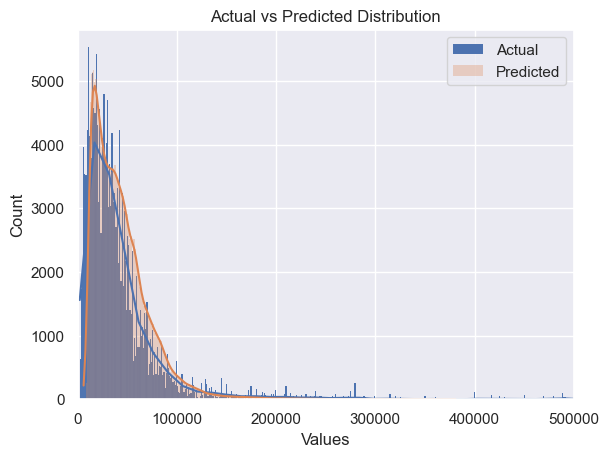

In [33]:
actual_vs_pred(y, model.predict(X))

In [23]:
# study_scores = study.trials_dataframe().set_index("number")["value"].tolist()

# min_score = study_scores[0]
# checkpoints = []
# for i, score in enumerate(study_scores):
#     if i <= 2:
#         continue
#     if score > min_score:
#         min_score = score
#         print(i, score)
#         checkpoints.append(i)

# best_params = {}
# models = {}
# test_predictions = {}
# for n in checkpoints[1:]:
#     params = study.trials[n].params
#     print("Running K-Fold CV on the Best Study Hyperparameters")
#     models[n], test_predictions[n] = run_cv_on_best_study_params(
#         X, y, test, params, random_state=random_state, kfold=kfold
#     )
#     print("Saving Outputs to Disk")
#     save_outputs(
#         model=models[n],
#         model_name=f"lgbm_model_base_features_hyperP_tune_{n}th_trial",
#         test_predictions=test_predictions[n],
#     )

# # Save the predictions
# submission["price"] = np.array(list(test_predictions.values())).mean(axis=0)
# submission.to_csv(
#     f"outputs/lgbm_model_base_features_hyperP_tune_checkpoint_mean.csv", index=False
# )
# submission.head()

# submission["price"] = np.average(
#     pd.DataFrame(test_predictions).values, axis=1, weights=[0.8, 0.2]
# )
# submission.to_csv(
#     f"outputs/lgbm_model_base_features_hyperP_tune_checkpoint_weighted_mean.csv",
#     index=False,
# )
# submission.head()

In [24]:
# from numpy.random import RandomState

# prng = RandomState(random_state)

# params = study.trials[11].params
# test_predictions = {}
# models = {}
# print("Running K-Fold CV on the Best Study Hyperparameters")
# for n in range(5):
#     models[n], test_predictions[n] = run_cv_on_best_study_params(
#         X, y, test, params, random_state=prng.randint(200), kfold=kfold
#     )
#     print("Saving Outputs to Disk")
#     save_outputs(
#         model=models[n],
#         model_name=f"lgbm_model_base_features_hyperP_tune_11th_trial_{n}_random_state",
#         test_predictions=test_predictions[n],
#     )

# # Save the predictions
# submission["price"] = np.array(list(test_predictions.values())).mean(axis=0)
# submission.to_csv(
#     f"outputs/lgbm_model_base_features_hyperP_tune_11th_trial_5_random_state_mean.csv",
#     index=False,
# )
# submission.head()

In [25]:
# optuna.delete_study(
#     study_name="lgbm_model_base_features_20_trials", storage="sqlite:///my_study.db"
# )

In [26]:
# optuna.copy_study(
#     from_study_name="lgbm_model_base_features_100_trials",
#     from_storage="sqlite:///my_study.db",
#     to_study_name="lgbm_model_base_features",
#     to_storage="sqlite:///my_study.db",
# )

In [34]:
train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,noise,2002,143250,Gasoline,noise,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,noise,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,noise,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,noise,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,noise,noise,None reported,Yes,349950
192538,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
192539,Porsche,noise,2022,2116,missing,Electric,Automatic,Black,Black,None reported,missing,90998
192540,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


# Feature Engineering

In [53]:
def feature_engineering(df):
    df["accident"] = df["accident"].map(
        {
            "None reported": "No",
            "At least 1 accident or damage reported": "Yes",
            "No": "No",
            "Yes": "Yes",
        }
    )

    def extract_hp(x):
        try:
            return float("".join(re.findall("(\d+)\.?\d*HP", x)))
        except:
            return None

    df["HP"] = df["engine"].apply(lambda x: extract_hp(x))

    def extract_cylinders(engine):
        pattern = (
            r"V[-\s]?(\d+)|I[-\s]?(\d+)|H[-\s]?(\d+)|W[-\s]?(\d+)|\b(\d+)\s*Cylinder\b"
        )
        match = re.search(pattern, engine)
        if match:
            return int(next(group for group in match.groups() if group is not None))
        return None

    df["cylinder"] = df["engine"].apply(extract_cylinders)

    def extract_engine_capacity(x):
        try:
            return float("".join(re.findall(r"\b(\d+.\d+)L", x)))
        except:
            return None

    df["engine_displacement"] = df["engine"].apply(lambda x: extract_engine_capacity(x))

    df["vehicle_age"] = df["model_year"].astype(int).max() - df["model_year"].astype(
        int
    )

    def extract_engine_valves(x):
        try:
            return float("".join(re.findall(r"\s(\d+)V\s", x)))
        except:
            return None

    df["valves"] = df["engine"].apply(lambda x: extract_engine_valves(x))

    df["transmission_base"] = df["transmission"].copy()
    conditions = [
        df["transmission"].str.contains(
            "A/T|Automatic|AT|CVT|Overdrive Switch|Variable"
        ),
        df["transmission"].str.contains("M/T|Manual|Mt"),
        df["transmission"].str.contains("At/Mt|Dual Shift Mode|6-Speed|7-Speed"),
        ~df["transmission"].str.contains(
            "A/T|Automatic|AT|CVT|Overdrive Switch|Variable|M/T|Manual|Mt|At/Mt|Dual Shift Mode|6-Speed|7-Speed"
        ),
    ]
    choices = ["Automatic", "Manual", "Both", "Other"]
    df["transmission_base"] = np.select(
        conditions, choices, default=df["transmission_base"]
    )
    df["transmission_base"] = pd.Categorical(df["transmission_base"])

    # bins = [50, 100, 200, 300, 400, 500, 600, float("inf")]
    # labels = ["50-100", "100-200", "200-300", "300-400", "400-500", "500-600", ">=600"]
    # df["HP_range"] = pd.cut(df["HP"], bins=bins, labels=labels, right=False)

    # bins = [0, 1.5, 2.5, 4.0, 6, float("inf")]
    # labels = ["Small", "Medium", "Large", "Very Large", "Extra Large"]
    # df["engine_displacement_group"] = pd.cut(
    #     df["engine_displacement"], bins=bins, labels=labels
    # )

    return df

In [62]:
train_feature_engg = feature_engineering(df=train.copy())
test_feature_engg = feature_engineering(df=test.copy())

train_feature_engg = clean_data(train_feature_engg)
test_feature_engg = clean_data(test_feature_engg)

In [63]:
X = train_feature_engg.drop(columns=["price"])
features = X.columns
y = train_feature_engg["price"]

Fold 1/10 -> Train RMSE: 65705.9637014807 Val RMSE: 72286.89525436464
Fold 2/10 -> Train RMSE: 64736.04857433969 Val RMSE: 78956.55894561588
Fold 3/10 -> Train RMSE: 65681.83460179674 Val RMSE: 74463.97341913664
Fold 4/10 -> Train RMSE: 66577.91862939206 Val RMSE: 62451.04953132605
Fold 5/10 -> Train RMSE: 65575.14619637994 Val RMSE: 71089.85785815127
Fold 6/10 -> Train RMSE: 66049.13940129716 Val RMSE: 69528.283479815
Fold 7/10 -> Train RMSE: 65199.66401930243 Val RMSE: 78646.13873430702
Fold 8/10 -> Train RMSE: 65565.64846071845 Val RMSE: 71828.51597711994
Fold 9/10 -> Train RMSE: 65857.89868030674 Val RMSE: 70704.62539051303
Fold 10/10 -> Train RMSE: 64912.19986798659 Val RMSE: 79902.46212197529
Train Mean Score: 65586.1462 ± 512.0661
Val Mean Score: 72985.8361 ± 5012.7450


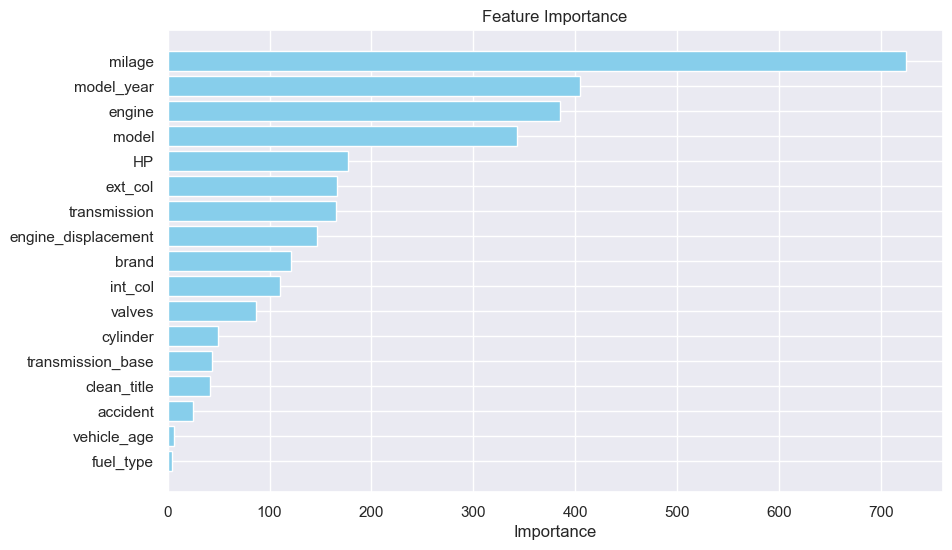

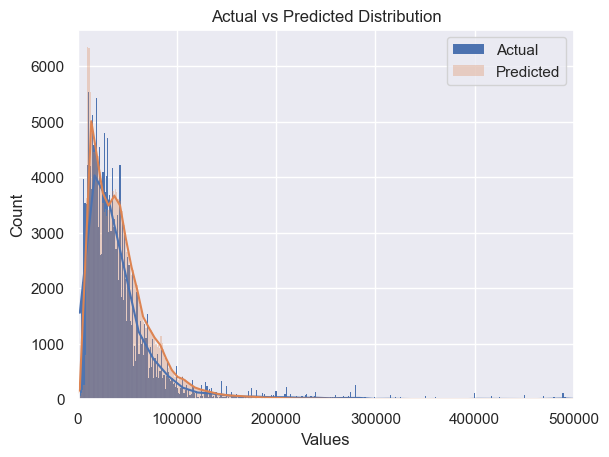

In [64]:
random_state = 42
kfold = 10

model = lgbm(random_state=random_state, verbose=-1)
model, test_prediction = k_fold_cv(
    model,
    X,
    y,
    test_feature_engg,
    k=kfold,
    scoring="root_mean_squared_error",
    random_state=random_state,
)

plot_feature_importance(model, features)

actual_vs_pred(y, model.predict(X))

In [65]:
# LB Score = 72889.79651

# Save the model
with open("outputs/lgbm_model_featur_engg_no_hyperP_tune.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the predictions
submission["price"] = test_prediction
submission.to_csv("outputs/lgbm_model_featur_engg_no_hyperP_tune.csv", index=False)
submission.head()

,id,price
0,188533,17078.925410
1,188534,82400.446179
2,188535,54508.336959
3,188536,27586.784299
4,188537,29921.490109


In [67]:
n_trials = 20
random_state = 42
kfold = 10

# Define the study name and storage path (local SQLite database file)
study_name = f"lgbm_model_feature_engg"
storage = "sqlite:///my_study.db"

study = execute_optuna(
    n_trials=n_trials, random_state=random_state, study_name=study_name
)

# Load the existing study
study = optuna.load_study(study_name=study_name, storage=storage)

[I 2024-09-06 12:24:56,959] A new study created in RDB with name: lgbm_model_feature_engg
[I 2024-09-06 12:25:03,392] Trial 0 finished with value: -73499.08297069577 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 48, 'reg_alpha': 0.07587945476302646, 'reg_lambda': 6.387926357773329, 'num_leaves': 89, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: -73499.08297069577.
[I 2024-09-06 12:25:23,398] Trial 1 finished with value: -73210.0857884255 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 34, 'reg_alpha': 0.0737265320016441, 'reg_lambda': 1.185260448662222, 'num_leaves': 293, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 1 with value: -73210.0857884255.
[I 2024-09-06 12:25:36,134] Trial 2 finished with value: -72700.07462605866 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 17, 'reg_alpha': 0.0373818018663584, 'reg_lambda': 5.72

Best Params: {'learning_rate': 0.028315740771223036, 'max_depth': 38, 'reg_alpha': 0.026503526805875827, 'reg_lambda': 4.480992487899914, 'num_leaves': 174, 'subsample': 0.22717075950647259, 'colsample_bytree': 0.48216537987834207}


Running K-Fold CV on the Best Study Hyperparameters
Fold 1/10 -> Train RMSE: 67517.6192606944 Val RMSE: 71988.44272750309
Fold 2/10 -> Train RMSE: 66656.5326329435 Val RMSE: 78305.74129648785
Fold 3/10 -> Train RMSE: 67286.30723292696 Val RMSE: 73882.06889131581
Fold 4/10 -> Train RMSE: 68298.9906168019 Val RMSE: 61766.555485087345
Fold 5/10 -> Train RMSE: 67541.80668104229 Val RMSE: 70404.31473800726
Fold 6/10 -> Train RMSE: 67778.88533925073 Val RMSE: 68699.51147844142
Fold 7/10 -> Train RMSE: 66830.71425740414 Val RMSE: 78536.93262393562
Fold 8/10 -> Train RMSE: 67510.2196944785 Val RMSE: 71083.54034994954
Fold 9/10 -> Train RMSE: 67516.47440631068 Val RMSE: 70574.83279691628
Fold 10/10 -> Train RMSE: 66606.23512819195 Val RMSE: 79453.77975485721
Train Mean Score: 67354.3785 ± 501.0391
Val Mean Score: 72469.5720 ± 5103.1741


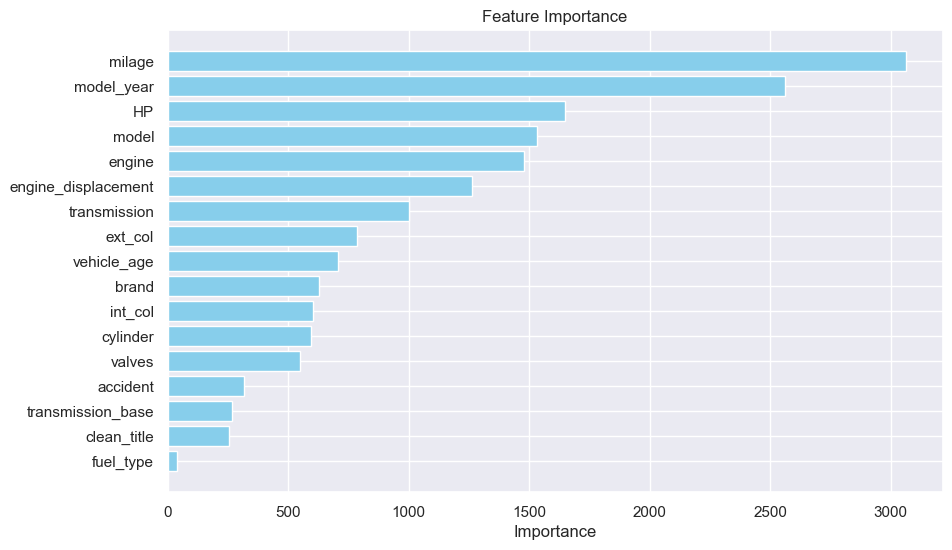

       id         price
0  188533  18792.041532
1  188534  75876.244010
2  188535  51622.844183
3  188536  31411.509866
4  188537  30556.952842


In [68]:
params = study.best_params
print("Running K-Fold CV on the Best Study Hyperparameters")
model, test_prediction = run_cv_on_best_study_params(
    X, y, test_feature_engg, params, random_state=random_state, kfold=kfold
)

save_outputs(
    model=model,
    model_name=f"lgbm_model_feature_engg_hyperP_tune",
    test_predictions=test_prediction,
)

# Leader Board RMSE Score:

In [27]:
# "lgbm_model_base_features_no_hyperP_tune" = 72697.18383
# "lgbm_model_base_features_hyperP_tune_11th_trial" = 72248.73451
#  all other trials have a LB score higher than the 11th , elbow point maybe??
# "lgbm_model_feature_engg_no_hyperP_tune" = 72889.79651